# Flight Fare  Prediction

**Objective :**<br>
Predicting flight ticket prices based on the ticket details. This is a regression analysis since we are dealing with predicting the continuous variable (Price).<br>

[**Click here to download the data**](https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh)



**Data Pre-processing Steps involved**
1. Dealing with missing data
2. Dealing with datetime features
3. Dealing with categorical features
4. Dealing with imputation
5. Feature Selection
6. Modelling

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import pickle

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for table display
sns.set_theme(style='whitegrid')
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 200)
from IPython.core import display as ICD
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Appending all functions in this block

def convert_to_date(df,col):
    df[col] = pd.to_datetime(df[col])
    

def convert_and_drop(df,col,suffix):
    """
    Transform datetime features
    """
    if suffix=='_hour':
        df[col+suffix] = df[col].dt.hour
    elif suffix=='_minute':
        df[col+suffix] = df[col].dt.minute
    elif suffix=='_day':
        df[col+suffix] = df[col].dt.day
    elif suffix=='_month':
        df[col+suffix] = df[col].dt.month

def transform_duration(x):
    """
    Transform the duration feature
    """
    if len(x.split())==2:
        return x
    else:
        if 'h' in x:
            return x + ' 0m'
        else:
            return '0h '+ x

def plot_dist(data,col):
    """
    Plot distributions of a continuous variable
    """
    fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10))
    ax1.set_title(f'Distribution of {col} with Skewness = {round(data[col].skew(),2)}',fontsize=16)
    sns.distplot(data[col],ax=ax1);
    sns.boxplot(data=data,x=col,ax=ax2);

def prediction(model,dump_filename=None):
    model.fit(X_train,y_train)
    print("Training Score : ",round(model.score(X_train,y_train),2))
    print("Test Score : ",round(model.score(X_test,y_test),2))


    y_pred = model.predict(X_test)
    print("R2 Score : ",round(r2_score(y_test,y_pred),2))
    print("MAE : ",round(mean_absolute_error(y_test,y_pred),2))
    print("MSE : ",round(mean_squared_error(y_test,y_pred),2))
    print("RMSE : ",round(np.sqrt(mean_squared_error(y_test,y_pred)),2))
    
    variance = pd.DataFrame(np.array(y_test)-y_pred,columns=['y_test-y_pred'])
    plot_dist(variance,'y_test-y_pred')
    
    if dump_filename is not None:
        print("Dumping model in path : ", "../Model/"+dump_filename+".pkl")
        with open("../Model/"+dump_filename+".pkl",'wb') as f:
            pickle.dump(model,f)
        
    

In [3]:
data = pd.read_excel('../Data/Data_Train.xlsx')

### 1. Dealing with Missing Data

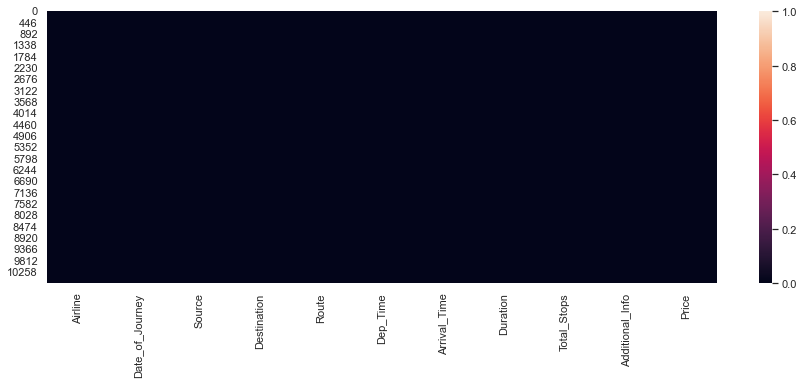

In [4]:
plt.figure(figsize=(15,5))
sns.heatmap(data.isnull());

In [5]:
print(data.isnull().sum(),data.shape,sep='\n')

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64
(10683, 11)


In [6]:
# Missing Values can be dropped
df1 = data.dropna(axis='rows')
df1.shape

(10682, 11)

### 2. Dealing with Datetime features

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


`Date_of_Journey` ---> `datetime`   _(extract day and month)_ <br>
`Dep_Time` ---> `datetime`   _(extract hour and minute)_ <br>
`Arrival_Time` ---> `datetime`   _(extract hour and minute)_ <br>
`Duration` ---> `numerical`  _(extract hour and minute)_<br>

In [8]:
# Original
df1.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [9]:
df2=df1.copy()

# convert the features to datetime; extract the necessary metrics
date_cols = ['Date_of_Journey','Dep_Time','Arrival_Time']
for i in date_cols:
    convert_to_date(df2,i)
    if i=='Date_of_Journey':
        convert_and_drop(df2,i,'_day')
        convert_and_drop(df2,i,'_month')
    else:
        convert_and_drop(df2,i,'_hour')
        convert_and_drop(df2,i,'_minute')

# extract hours and minutes from Duration column; convert them to integers
df2['Duration'] = df2['Duration'].apply(lambda x : transform_duration(x))
df2['Duration_hour']  = df2['Duration'].apply(lambda x : int(x.split(' ')[0][0:-1]))
df2['Duration_minute']  = df2['Duration'].apply(lambda x : int(x.split(' ')[1][0:-1]))


# drop unnecessary columns
df2.drop(columns=date_cols+['Duration'],inplace=True)

df2.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Airline                10682 non-null  object
 1   Source                 10682 non-null  object
 2   Destination            10682 non-null  object
 3   Route                  10682 non-null  object
 4   Total_Stops            10682 non-null  object
 5   Additional_Info        10682 non-null  object
 6   Price                  10682 non-null  int64 
 7   Date_of_Journey_day    10682 non-null  int64 
 8   Date_of_Journey_month  10682 non-null  int64 
 9   Dep_Time_hour          10682 non-null  int64 
 10  Dep_Time_minute        10682 non-null  int64 
 11  Arrival_Time_hour      10682 non-null  int64 
 12  Arrival_Time_minute    10682 non-null  int64 
 13  Duration_hour          10682 non-null  int64 
 14  Duration_minute        10682 non-null  int64 
dtypes: int64(9), object

In [11]:
# Gather all numerical features in one dataframe

num_cols = [col for col in df2.columns if df2[col].dtype!='O']
print("Numerical columns : ",num_cols)
numerical = df2[num_cols].copy()

Numerical columns :  ['Price', 'Date_of_Journey_day', 'Date_of_Journey_month', 'Dep_Time_hour', 'Dep_Time_minute', 'Arrival_Time_hour', 'Arrival_Time_minute', 'Duration_hour', 'Duration_minute']


### 3. Dealing with Categorical Features

In [12]:
# Extract categorical columns
cat_cols = [col for col in df2.columns if df2[col].dtype=='O']
df_cat = df2[cat_cols].copy()
print(cat_cols)
print(df2[cat_cols].nunique())

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']
Airline             12
Source               5
Destination          6
Route              128
Total_Stops          5
Additional_Info     10
dtype: int64


Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64


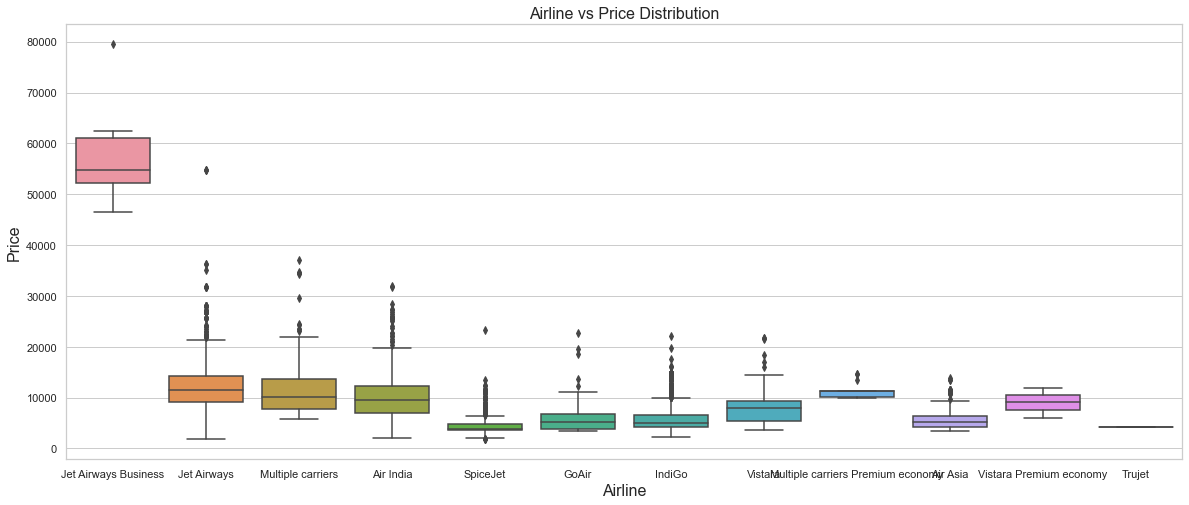

In [13]:
# Airline vs Price Distribution

print(df2['Airline'].value_counts())

plt.figure(figsize=(20,8))
plt.title('Airline vs Price Distribution',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.xlabel('Airline',fontsize=16)

sns.boxplot(data=df2.sort_values(by='Price',ascending=False),x='Airline',y='Price');

_Jet Airways charged tickets at a higher rate with negligible fluctuation.<br>
Other Airlines charged tickets almost within the same range._

Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64


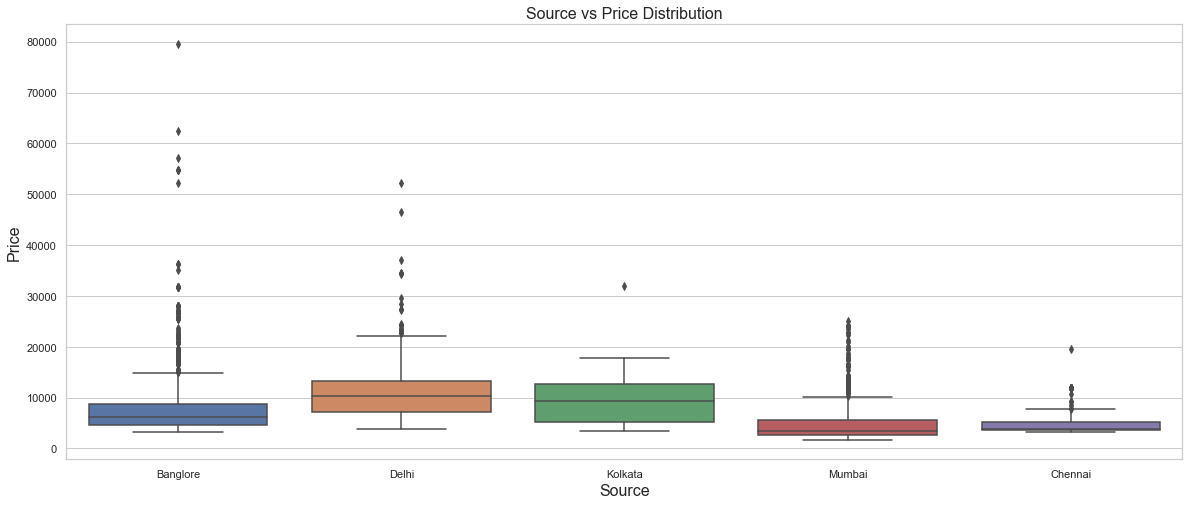

In [14]:
# Source vs Price Distribution

print(df2['Source'].value_counts())

plt.figure(figsize=(20,8))
plt.title('Source vs Price Distribution',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.xlabel('Source',fontsize=16)

sns.boxplot(data=df2.sort_values(by='Price',ascending=False),x='Source',y='Price');

Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64


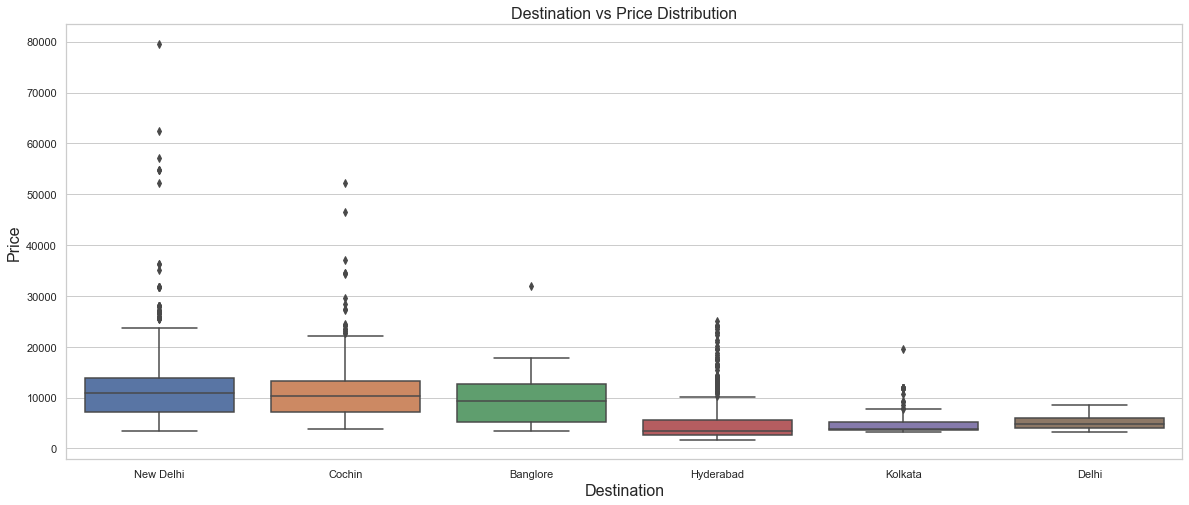

In [15]:
# Destination vs Price Distribution

print(df2['Destination'].value_counts())

plt.figure(figsize=(20,8))
plt.title('Destination vs Price Distribution',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.xlabel('Destination',fontsize=16)

sns.boxplot(data=df2.sort_values(by='Price',ascending=False),x='Destination',y='Price');

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64


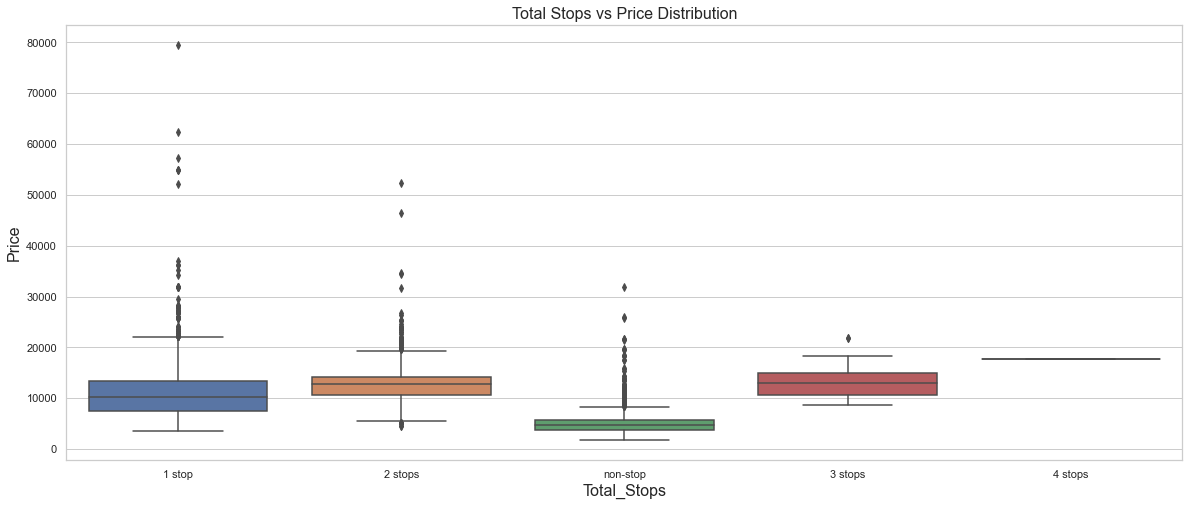

In [16]:
# Total Stops vs Price Distribution

print(df2['Total_Stops'].value_counts())


plt.figure(figsize=(20,8))
plt.title('Total Stops vs Price Distribution',fontsize=16)
plt.ylabel('Price',fontsize=16)
plt.xlabel('Total Stops',fontsize=16)

sns.boxplot(data=df2.sort_values(by='Price',ascending=False),x='Total_Stops',y='Price');

In [17]:
# DEALING WITH 'Route' COLUMN

print(df2['Route'].head(5))
print('\n')
print("Distinct number of routes : ",df2['Route'].apply(lambda x: len(x.split('→'))).unique())
print("Maximum number of routes → 6-1=5")

# Split the routes into 5 (maximum routes) seperate columns
df_cat['Route_1']=df_cat['Route'].str.split('→').str[0]
df_cat['Route_2']=df_cat['Route'].str.split('→').str[1]
df_cat['Route_3']=df_cat['Route'].str.split('→').str[2]
df_cat['Route_4']=df_cat['Route'].str.split('→').str[3]
df_cat['Route_5']=df_cat['Route'].str.split('→').str[4]

# replace empty routes with 'None'
for i in ['Route_3','Route_4','Route_5']:
    df_cat[i].fillna('None',inplace=True)

# drop original column
df_cat.drop(columns='Route',inplace=True)
df_cat.head()

0                BLR → DEL
1    CCU → IXR → BBI → BLR
2    DEL → LKO → BOM → COK
3          CCU → NAG → BLR
4          BLR → NAG → DEL
Name: Route, dtype: object


Distinct number of routes :  [2 4 3 5 6]
Maximum number of routes → 6-1=5


,Airline,Source,Destination,Total_Stops,Additional_Info,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,non-stop,No info,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,2 stops,No info,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,2 stops,No info,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,1 stop,No info,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,1 stop,No info,BLR,NAG,DEL,None,None


In [18]:
print("No. of distinct values in each categorical feature")
df_cat.nunique()

No. of distinct values in each categorical feature


Airline            12
Source              5
Destination         6
Total_Stops         5
Additional_Info    10
Route_1             5
Route_2            45
Route_3            30
Route_4            14
Route_5             6
dtype: int64

**Encoding Approach**<br>
- One-hot encoding needed for ['Airline','Source','Destination'].
- 'Total_Stops' can be converted to number of stops. (non-stop→0, 1 stop→1, 2 stops→2, ...)
- 'Additional_Info' can be dropped.
- Label encoding needed for the 5 Routes.

In [19]:
# One hot encoding

Airline = pd.get_dummies(df_cat['Airline'],drop_first=True)
Source = pd.get_dummies(df_cat['Source'],drop_first=True)
Destination = pd.get_dummies(df_cat['Destination'],drop_first=True)
ICD.display('Airline',Airline.head())
ICD.display('Source',Source.head())
ICD.display('Destination',Destination.head())


'Airline'

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


'Source'

,Chennai,Delhi,Kolkata,Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


'Destination'

,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,0,0,0,0,1
1,0,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [20]:
# Label Encoding

label_enc = LabelEncoder()
route_cols = ['Route_1', 'Route_2','Route_3', 'Route_4', 'Route_5']
Routes=df_cat[route_cols].copy()

for i in route_cols:
    Routes[i]=label_enc.fit_transform(Routes[i])

ICD.display('Routes',Routes.head())

'Routes'

,Route_1,Route_2,Route_3,Route_4,Route_5
0,0,13,29,13,5
1,2,25,1,3,5
2,3,32,4,5,5
3,2,34,3,13,5
4,0,34,8,13,5


In [21]:
# Custom encoding on 'Total_Stops'

ICD.display(df_cat['Total_Stops'].head())
print("Distinct Total_Stops : ",df_cat['Total_Stops'].unique())
dict_stops = {'non-stop':0,'1 stop':1,'2 stops':2,'3 stops':3,'4 stops':4}
Total_Stops = df_cat['Total_Stops'].map(dict_stops)
ICD.display('Total_Stops',Total_Stops.head())

0    non-stop
1     2 stops
2     2 stops
3      1 stop
4      1 stop
Name: Total_Stops, dtype: object

Distinct Total_Stops :  ['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']


'Total_Stops'

0    0
1    2
2    2
3    1
4    1
Name: Total_Stops, dtype: int64

In [22]:
# Merge all transformed columns
categorical = pd.concat([Airline,Source,Destination,Routes,Total_Stops],axis=1)
df3 = pd.concat([categorical,numerical],axis=1)
df3.head()

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Route_1,Route_2,Route_3,Route_4,Route_5,Total_Stops,Price,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13,29,13,5,0,3897,24,3,22,20,1,10,2,50
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,25,1,3,5,2,7662,5,1,5,50,13,15,7,25
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,32,4,5,5,2,13882,6,9,9,25,4,25,19,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,34,3,13,5,1,6218,5,12,18,5,23,30,5,25
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,34,8,13,5,1,13302,3,1,16,50,21,35,4,45


### 4. Dealing with Imputation

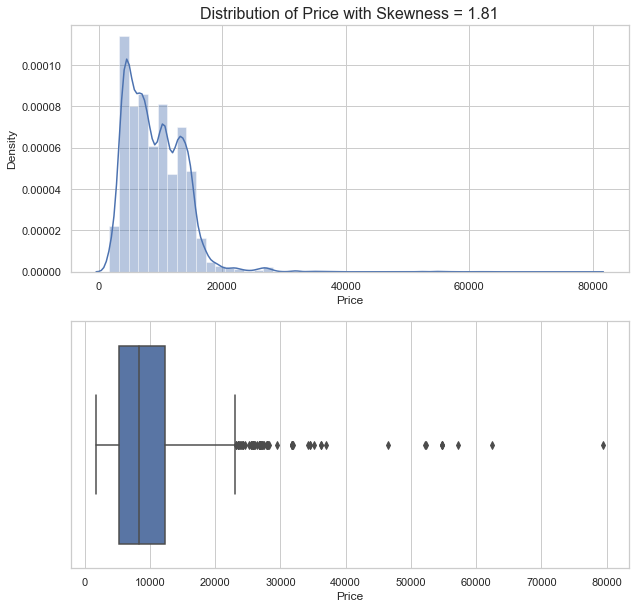

In [23]:
df4=df3.copy()
plot_dist(df4,'Price')

Prices > 40000 could be considered as outliers, to be replaced with median price.

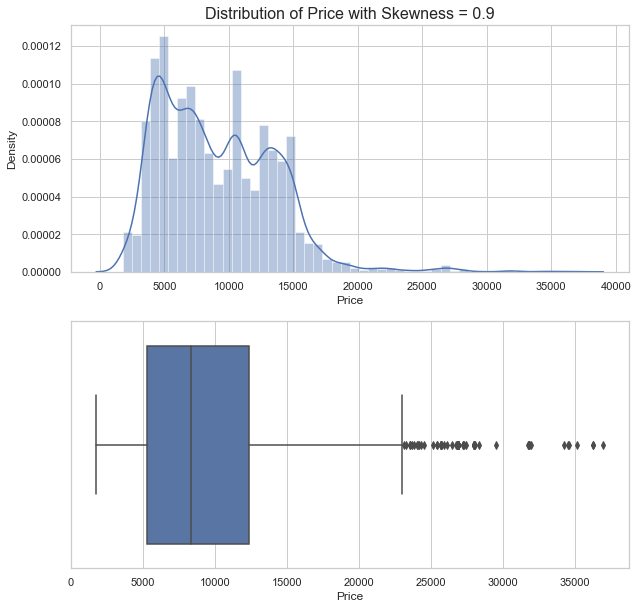

In [24]:
df4['Price'] = np.where(df4['Price']>40000,df4['Price'].median(),df4['Price'])
plot_dist(df4,'Price')

In [25]:
X = df4.drop(columns='Price')
y = df4['Price']
print(X.shape,y.shape)

(10682, 34) (10682,)


In [26]:
ICD.display('Features',X.head())
ICD.display('Target',y.head())

'Features'

,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Route_1,Route_2,Route_3,Route_4,Route_5,Total_Stops,Date_of_Journey_day,Date_of_Journey_month,Dep_Time_hour,Dep_Time_minute,Arrival_Time_hour,Arrival_Time_minute,Duration_hour,Duration_minute
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13,29,13,5,0,24,3,22,20,1,10,2,50
1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,25,1,3,5,2,5,1,5,50,13,15,7,25
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,3,32,4,5,5,2,6,9,9,25,4,25,19,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,34,3,13,5,1,5,12,18,5,23,30,5,25
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,34,8,13,5,1,3,1,16,50,21,35,4,45


'Target'

0     3897.0
1     7662.0
2    13882.0
3     6218.0
4    13302.0
Name: Price, dtype: float64

### 5. Feature Selection

In [27]:
# Top 5 correlated features with Price (by magnitude)
corr_price = df4.corr()[['Price']]
corr_price['abs_Price'] = corr_price.abs()
corr_price = corr_price.sort_values(by='abs_Price',ascending=False)
corr_price.head(5)

,Price,abs_Price
Price,1.000000,1.000000
Total_Stops,0.629704,0.629704
Route_3,-0.616544,0.616544
Duration_hour,0.539566,0.539566
Jet Airways,0.438216,0.438216


In [28]:
# Bottom 5 correlated features with Price
corr_price.tail(5)

,Price,abs_Price
Kolkata,0.015518,0.015518
Trujet,-0.010820,0.010820
Dep_Time_hour,0.006999,0.006999
Jet Airways Business,-0.003642,0.003642
Vistara Premium economy,-0.000320,0.000320


In [29]:
# Sorting features based on importance
col_dep = pd.DataFrame(mutual_info_classif(X,y),index=X.columns,columns=['Importance'])
col_dep.sort_values(inplace=True,by='Importance',ascending=False)
col_dep.head(5)

,Importance
Route_2,2.753513
Route_3,2.289109
Total_Stops,2.133751
Route_1,2.038381
Arrival_Time_hour,1.850374


In [30]:
col_dep.tail(5)

,Importance
GoAir,0.106719
Multiple carriers Premium economy,0.012712
Jet Airways Business,0.009814
Vistara Premium economy,0.003221
Trujet,0.000000


Based on the two observations, feature 'Jet Airways Business' can be dropped due to irrelevance with the target variable - Price

### 6. Modelling

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=27)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8545, 34) (2137, 34) (8545,) (2137,)


Training Score :  0.61
Test Score :  0.62
R2 Score :  0.62
MAE :  1975.17
MSE :  7915676.78
RMSE :  2813.48
Dumping model in path :  ../Model/LinearRegression_model.pkl


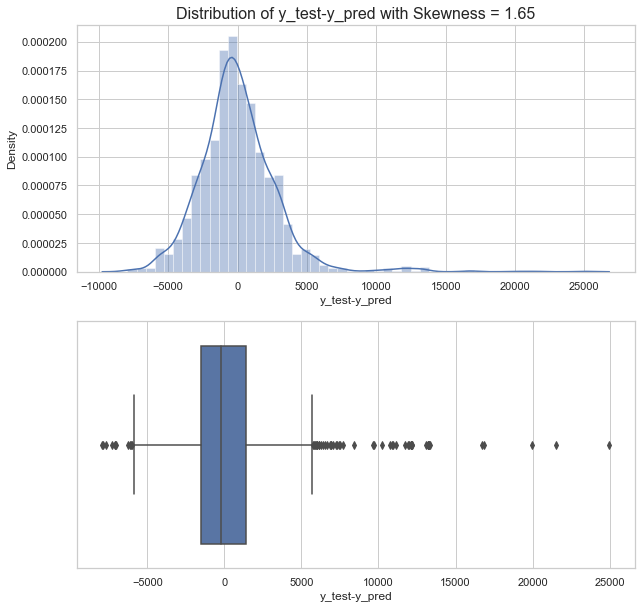

In [32]:
# Linear Regression
lr = LinearRegression()
prediction(lr,'LinearRegression_model')

Training Score :  0.95
Test Score :  0.82
R2 Score :  0.82
MAE :  1177.31
MSE :  3706712.07
RMSE :  1925.28
Dumping model in path :  ../Model/RandomForest_model.pkl


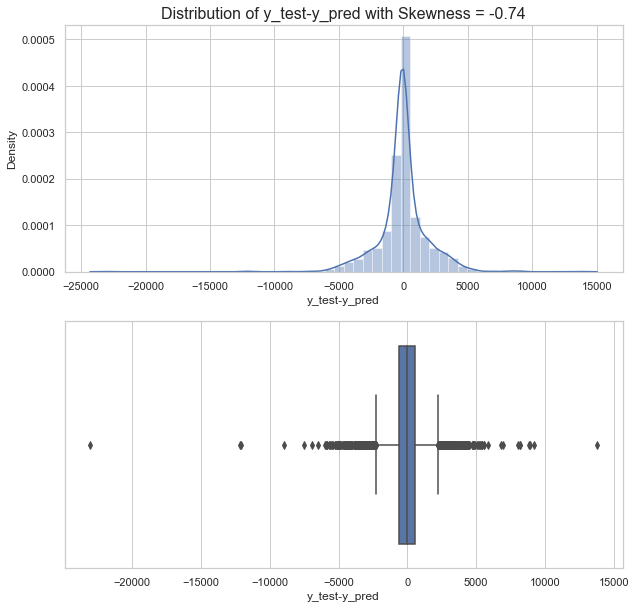

In [33]:
# Random Forest
rf = RandomForestRegressor()
prediction(rf,'RandomForest_model')

Training Score :  0.88
Test Score :  0.36
R2 Score :  0.69
MAE :  1414.25
MSE :  6431420.08
RMSE :  2536.02


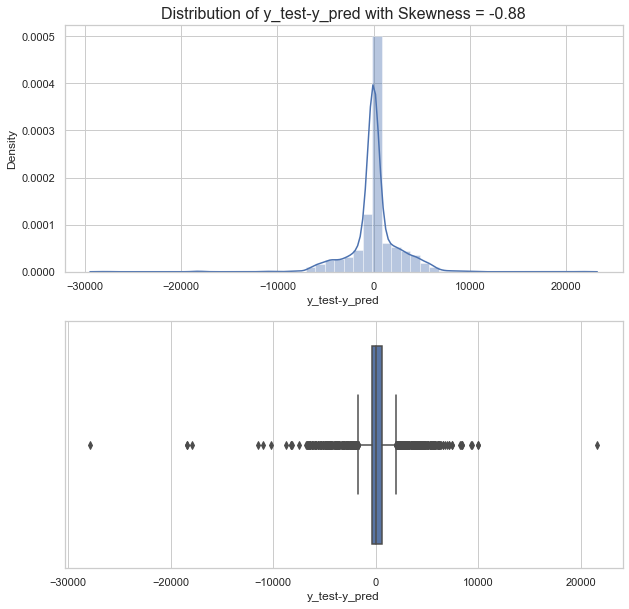

In [34]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
prediction(dt)

_**Note** : Not saving the pickle file as model score is low and file size exceeds 100 MB_

Training Score :  0.78
Test Score :  0.64
R2 Score :  0.64
MAE :  1799.66
MSE :  7467146.82
RMSE :  2732.61
Dumping model in path :  ../Model/KNN_model.pkl


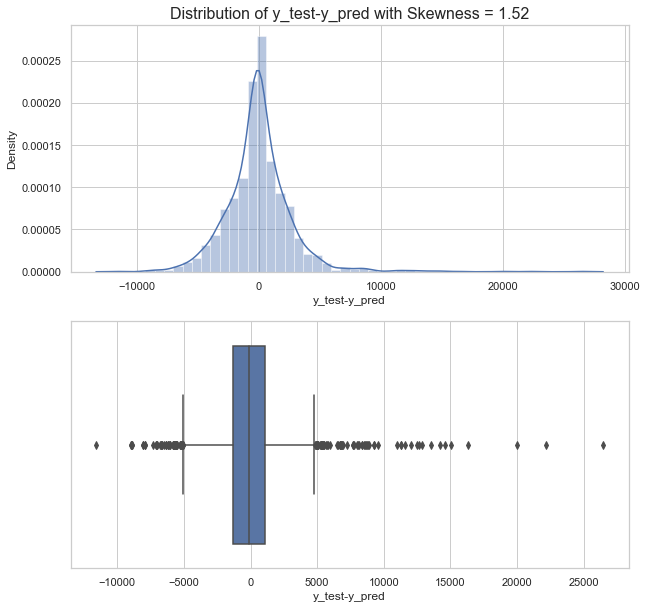

In [35]:
# KNN
knn = KNeighborsRegressor()
prediction(knn,'KNN_model')